In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import pprint
import librosa
import soundfile as sf
import random as random
import IPython.display as ipd
import tensorflow_addons as tfa
import gzip
import pickle
import tensorflow.keras.backend as K
import keras
from itertools import combinations,product
from sklearn.model_selection import train_test_split
from tensorflow.keras import initializers
from keras.models import Sequential, Model
from keras import models
from keras.layers import Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D, GRU, Dropout, Input, Lambda, Layer, Reshape, Conv2DTranspose, LeakyReLU, BatchNormalization, LSTM, concatenate, UpSampling2D
from keras.layers.core import RepeatVector, Permute
from keras.optimizers import Adam
from keras.models import load_model
from tensorflow.linalg import svd
from itertools import combinations,product
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from PIL import Image

In [2]:
x_ae=[]
for f in os.listdir('Train/Train/'):
    x_ae.append(np.array(Image.open('Train/Train/'+f)))
x_ae_tr=np.array(x_ae, dtype=float)
x_ae_train=x_ae_tr/255

In [3]:
inet=InceptionResNetV2()
inet.run_eagerly=False
inet.graph=tf.compat.v1.get_default_graph()

## Encoder Model

In [4]:
a_enc='relu'
padding_enc='same'

In [5]:
train_shape=list(x_ae_train.shape[1:3])
train_shape.append(1)

In [6]:
model_enc=Sequential()
model_enc.add(Conv2D(64, (3,3), strides=2, padding=padding_enc, activation=a_enc))
model_enc.add(Conv2D(128, (3,3), padding=padding_enc, activation=a_enc))
model_enc.add(Conv2D(128, (3,3), strides=2, padding=padding_enc, activation=a_enc))
model_enc.add(Conv2D(256, (3,3), padding=padding_enc, activation=a_enc))
model_enc.add(Conv2D(256, (3,3), strides=2, padding=padding_enc, activation=a_enc))
model_enc.add(Conv2D(512, (3,3), padding=padding_enc, activation=a_enc))
model_enc.add(Conv2D(512, (3,3), padding=padding_enc, activation=a_enc))
model_enc.add(Conv2D(256, (3,3), padding=padding_enc, activation=a_enc))

In [7]:
enc_ip=Input(train_shape)
enc=model_enc(enc_ip)

## Categorize model

In [8]:
categ=list((1000,))

In [9]:
model_cat=Sequential()
model_cat.add(RepeatVector(1024))
model_cat.add(Reshape(([32,32,1000])))

In [10]:
cat_ip=Input(categ)
cat=model_cat(cat_ip)

## Merge model

In [11]:
a_merge='relu'
padding_perge='same'

In [14]:
model_merge=concatenate([enc,cat],axis=3)
model_merge=(Conv2D(256,(1, 1), activation=a_merge, padding=padding_perge))(model_merge)

## Decoder model

In [15]:
a_dec='relu'
padding_dec='same'

In [18]:
model_dec=Sequential()
model_dec.add(Conv2D(128, (3,3), padding=padding_dec, activation=a_dec))
model_dec.add(UpSampling2D((2, 2)))
model_dec.add(Conv2D(64, (3,3), padding=padding_dec, activation=a_dec))
model_dec.add(UpSampling2D((2, 2)))
model_dec.add(Conv2D(256, (3,3), padding=padding_dec, activation=a_dec))
model_dec.add(Conv2D(32, (3,3), padding=padding_dec, activation=a_dec))
model_dec.add(Conv2D(16, (3,3), padding=padding_dec, activation=a_dec))
model_dec.add(Conv2D(2, (3,3), padding=padding_dec, activation='tanh'))
model_dec.add(UpSampling2D((2, 2)))

In [19]:
dec=model_dec(model_merge)

## Combined Model

In [20]:
model_ae=Model(inputs=[enc_ip,cat_ip], outputs=dec)

In [21]:
model_ae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32, 32, 256)  5827200     ['input_2[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 1000  0           ['input_3[0][0]']            

### Changing input size to fit Transfer Learning model

In [22]:
def inc_fit(bw):
    bw_mod=[]
    for i in bw:
        i=resize(i,(299,299,3),mode='constant')
        bw_mod.append(i)
    bw_mod=np.array(bw_mod)
    bw_pr=preprocess_input(bw_mod)
    inet.run_eagerly=True
    bw_fit=inet.predict(bw_pr)
    return bw_fit

### Using image generator for multiple iterations

In [23]:
gen_data=ImageDataGenerator(shear_range=0.2,zoom_range=0.2,rotation_range=20,horizontal_flip=True)

### Using lab data instead of rgb to seperate lightness and red/green+blue/yellow values as ip and op

In [24]:
def training_data(n):
    for imgs in gen_data.flow(x_ae_train,batch_size=n):
        conv_img=rgb2lab(imgs)
        l_val=conv_img[:,:,:,0]
        l_val=np.expand_dims(l_val,axis=-1)
        ab_val=conv_img[:,:,:,1:]/128
        bw=gray2rgb(rgb2gray(imgs))
        mod_data=inc_fit(bw)
        yield([l_val,mod_data],ab_val)

## Training the model

In [25]:
model_ae.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [26]:
model_ae.fit(training_data(10),steps_per_epoch=1,epochs=1000)

1/1 [==============================] - 14s 14s/step
Epoch 1/1000
1/1 [==============================] - 16s 16s/step - loss: 0.0130 - accuracy: 0.4900
Epoch 2/1000
1/1 [==============================] - 0s 371ms/step - loss: 0.1540 - accuracy: 0.4498
Epoch 3/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0074 - accuracy: 0.4502
Epoch 4/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0073 - accuracy: 0.4463
Epoch 5/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0068 - accuracy: 0.4756
Epoch 6/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0120 - accuracy: 0.4810
Epoch 7/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0069 - accuracy: 0.4613
Epoch 8/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0068 - accuracy: 0.4633
Epoch 9/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0066 - accuracy: 0.3897
Epoch 10/1000
1/1 [==============================] - 2s 2s/step - loss

1/1 [==============================] - 2s 2s/step - loss: 0.0054 - accuracy: 0.5594
Epoch 56/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0053 - accuracy: 0.5574
Epoch 57/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0056 - accuracy: 0.5427
Epoch 58/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0058 - accuracy: 0.5462
Epoch 59/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0051 - accuracy: 0.5379
Epoch 60/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0054 - accuracy: 0.5489
Epoch 61/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0056 - accuracy: 0.5464
Epoch 62/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0052 - accuracy: 0.5353
Epoch 63/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0054 - accuracy: 0.5585
Epoch 64/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0053 - accuracy: 0.5472
Epoch 65/1000
1/1 [===============

1/1 [==============================] - 2s 2s/step - loss: 0.0058 - accuracy: 0.5375
Epoch 110/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0058 - accuracy: 0.5459
Epoch 111/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0056 - accuracy: 0.5306
Epoch 112/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0055 - accuracy: 0.5359
Epoch 113/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0058 - accuracy: 0.5899
Epoch 114/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0056 - accuracy: 0.5387
Epoch 115/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0058 - accuracy: 0.4949
Epoch 116/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0056 - accuracy: 0.4892
Epoch 117/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0058 - accuracy: 0.5097
Epoch 118/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0059 - accuracy: 0.5103
Epoch 119/1000
1/1 [=====

1/1 [==============================] - 2s 2s/step - loss: 0.0057 - accuracy: 0.5296
Epoch 164/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0056 - accuracy: 0.4969
Epoch 165/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0054 - accuracy: 0.5049
Epoch 166/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0054 - accuracy: 0.5114
Epoch 167/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0050 - accuracy: 0.5598
Epoch 168/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0051 - accuracy: 0.5920
Epoch 169/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0050 - accuracy: 0.5955
Epoch 170/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0049 - accuracy: 0.5960
Epoch 171/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0051 - accuracy: 0.5745
Epoch 172/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0051 - accuracy: 0.5963
Epoch 173/1000
1/1 [=====

1/1 [==============================] - 2s 2s/step - loss: 0.0043 - accuracy: 0.6200
Epoch 218/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0046 - accuracy: 0.6133
Epoch 219/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0046 - accuracy: 0.6161
Epoch 220/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0043 - accuracy: 0.6039
Epoch 221/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0047 - accuracy: 0.6303
Epoch 222/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0046 - accuracy: 0.6208
Epoch 223/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0047 - accuracy: 0.6046
Epoch 224/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0043 - accuracy: 0.6078
Epoch 225/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0044 - accuracy: 0.6150
Epoch 226/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0048 - accuracy: 0.6309
Epoch 227/1000
1/1 [=====

Epoch 271/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0039 - accuracy: 0.6276
Epoch 272/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0040 - accuracy: 0.6082
Epoch 273/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0042 - accuracy: 0.6304
Epoch 274/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0039 - accuracy: 0.6272
Epoch 275/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0040 - accuracy: 0.6180
Epoch 276/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0036 - accuracy: 0.5866
Epoch 277/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0038 - accuracy: 0.6158
Epoch 278/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0037 - accuracy: 0.5969
Epoch 279/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0036 - accuracy: 0.6279
Epoch 280/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0036 - accuracy: 0.6352
Epoch 281/

1/1 [==============================] - 2s 2s/step - loss: 0.0033 - accuracy: 0.6042
Epoch 325/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0033 - accuracy: 0.6350
Epoch 326/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0035 - accuracy: 0.6544
Epoch 327/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0031 - accuracy: 0.6731
Epoch 328/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0031 - accuracy: 0.6478
Epoch 329/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0031 - accuracy: 0.6485
Epoch 330/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0031 - accuracy: 0.6396
Epoch 331/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0032 - accuracy: 0.6454
Epoch 332/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0029 - accuracy: 0.6481
Epoch 333/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0035 - accuracy: 0.6415
Epoch 334/1000
1/1 [=====

1/1 [==============================] - 1s 989ms/step - loss: 0.0026 - accuracy: 0.6493
Epoch 378/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - accuracy: 0.6346
Epoch 379/1000
1/1 [==============================] - 1s 955ms/step - loss: 0.0026 - accuracy: 0.6519
Epoch 380/1000
1/1 [==============================] - 1s 971ms/step - loss: 0.0029 - accuracy: 0.6330
Epoch 381/1000
1/1 [==============================] - 1s 992ms/step - loss: 0.0025 - accuracy: 0.6624
Epoch 382/1000
1/1 [==============================] - 1s 985ms/step - loss: 0.0029 - accuracy: 0.6526
Epoch 383/1000
1/1 [==============================] - 1s 992ms/step - loss: 0.0024 - accuracy: 0.6589
Epoch 384/1000
1/1 [==============================] - 1s 974ms/step - loss: 0.0029 - accuracy: 0.6517
Epoch 385/1000
1/1 [==============================] - 1s 998ms/step - loss: 0.0025 - accuracy: 0.6616
Epoch 386/1000
1/1 [==============================] - 1s 976ms/step - loss: 0.0030 - accuracy: 0.639

1/1 [==============================] - 1s 998ms/step - loss: 0.0026 - accuracy: 0.6763
Epoch 431/1000
1/1 [==============================] - 1s 975ms/step - loss: 0.0025 - accuracy: 0.6877
Epoch 432/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0025 - accuracy: 0.6820
Epoch 433/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0025 - accuracy: 0.6693
Epoch 434/1000
1/1 [==============================] - 1s 986ms/step - loss: 0.0024 - accuracy: 0.6651
Epoch 435/1000
1/1 [==============================] - 1s 955ms/step - loss: 0.0024 - accuracy: 0.6724
Epoch 436/1000
1/1 [==============================] - 1s 964ms/step - loss: 0.0027 - accuracy: 0.6692
Epoch 437/1000
1/1 [==============================] - 1s 955ms/step - loss: 0.0022 - accuracy: 0.6579
Epoch 438/1000
1/1 [==============================] - 1s 945ms/step - loss: 0.0023 - accuracy: 0.6907
Epoch 439/1000
1/1 [==============================] - 1s 990ms/step - loss: 0.0024 - accuracy: 0.6832
E

1/1 [==============================] - 1s 934ms/step - loss: 0.0020 - accuracy: 0.7181
Epoch 484/1000
1/1 [==============================] - 1s 929ms/step - loss: 0.0019 - accuracy: 0.7009
Epoch 485/1000
1/1 [==============================] - 1s 941ms/step - loss: 0.0021 - accuracy: 0.7084
Epoch 486/1000
1/1 [==============================] - 1s 953ms/step - loss: 0.0020 - accuracy: 0.7001
Epoch 487/1000
1/1 [==============================] - 1s 939ms/step - loss: 0.0019 - accuracy: 0.6907
Epoch 488/1000
1/1 [==============================] - 1s 992ms/step - loss: 0.0020 - accuracy: 0.6857
Epoch 489/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0020 - accuracy: 0.7060
Epoch 490/1000
1/1 [==============================] - 1s 961ms/step - loss: 0.0019 - accuracy: 0.7142
Epoch 491/1000
1/1 [==============================] - 1s 960ms/step - loss: 0.0018 - accuracy: 0.7006
Epoch 492/1000
1/1 [==============================] - 1s 982ms/step - loss: 0.0019 - accuracy: 0.705

1/1 [==============================] - 1s 982ms/step - loss: 0.0018 - accuracy: 0.7439
Epoch 537/1000
1/1 [==============================] - 1s 982ms/step - loss: 0.0019 - accuracy: 0.7217
Epoch 538/1000
1/1 [==============================] - 1s 958ms/step - loss: 0.0017 - accuracy: 0.7133
Epoch 539/1000
1/1 [==============================] - 1s 985ms/step - loss: 0.0017 - accuracy: 0.7405
Epoch 540/1000
1/1 [==============================] - 1s 964ms/step - loss: 0.0017 - accuracy: 0.7291
Epoch 541/1000
1/1 [==============================] - 1s 970ms/step - loss: 0.0016 - accuracy: 0.7252
Epoch 542/1000
1/1 [==============================] - 1s 967ms/step - loss: 0.0016 - accuracy: 0.7490
Epoch 543/1000
1/1 [==============================] - 1s 953ms/step - loss: 0.0017 - accuracy: 0.7241
Epoch 544/1000
1/1 [==============================] - 1s 985ms/step - loss: 0.0015 - accuracy: 0.7312
Epoch 545/1000
1/1 [==============================] - 1s 983ms/step - loss: 0.0016 - accuracy: 0.

1/1 [==============================] - 1s 998ms/step - loss: 0.0015 - accuracy: 0.7559
Epoch 590/1000
1/1 [==============================] - 1s 988ms/step - loss: 0.0016 - accuracy: 0.7533
Epoch 591/1000
1/1 [==============================] - 1s 992ms/step - loss: 0.0015 - accuracy: 0.7377
Epoch 592/1000
1/1 [==============================] - 1s 977ms/step - loss: 0.0014 - accuracy: 0.7584
Epoch 593/1000
1/1 [==============================] - 1s 995ms/step - loss: 0.0015 - accuracy: 0.7509
Epoch 594/1000
1/1 [==============================] - 1s 983ms/step - loss: 0.0013 - accuracy: 0.7643
Epoch 595/1000
1/1 [==============================] - 1s 963ms/step - loss: 0.0015 - accuracy: 0.7406
Epoch 596/1000
1/1 [==============================] - 1s 991ms/step - loss: 0.0015 - accuracy: 0.7423
Epoch 597/1000
1/1 [==============================] - 1s 994ms/step - loss: 0.0015 - accuracy: 0.7571
Epoch 598/1000
1/1 [==============================] - 1s 992ms/step - loss: 0.0013 - accuracy: 0.

1/1 [==============================] - 1s 933ms/step - loss: 0.0013 - accuracy: 0.7836
Epoch 643/1000
1/1 [==============================] - 1s 944ms/step - loss: 0.0013 - accuracy: 0.7892
Epoch 644/1000
1/1 [==============================] - 1s 968ms/step - loss: 0.0013 - accuracy: 0.7859
Epoch 645/1000
1/1 [==============================] - 1s 951ms/step - loss: 0.0014 - accuracy: 0.7912
Epoch 646/1000
1/1 [==============================] - 1s 993ms/step - loss: 0.0013 - accuracy: 0.7763
Epoch 647/1000
1/1 [==============================] - 1s 963ms/step - loss: 0.0013 - accuracy: 0.7587
Epoch 648/1000
1/1 [==============================] - 1s 914ms/step - loss: 0.0013 - accuracy: 0.7744
Epoch 649/1000
1/1 [==============================] - 1s 956ms/step - loss: 0.0013 - accuracy: 0.7617
Epoch 650/1000
1/1 [==============================] - 1s 961ms/step - loss: 0.0013 - accuracy: 0.7708
Epoch 651/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0014 - accuracy: 0.754

1/1 [==============================] - 1s 978ms/step - loss: 0.0012 - accuracy: 0.7881
Epoch 696/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0013 - accuracy: 0.7861
Epoch 697/1000
1/1 [==============================] - 1s 992ms/step - loss: 0.0012 - accuracy: 0.7963
Epoch 698/1000
1/1 [==============================] - 1s 949ms/step - loss: 0.0012 - accuracy: 0.7733
Epoch 699/1000
1/1 [==============================] - 1s 985ms/step - loss: 0.0012 - accuracy: 0.7854
Epoch 700/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0013 - accuracy: 0.7970
Epoch 701/1000
1/1 [==============================] - 1s 986ms/step - loss: 0.0012 - accuracy: 0.7884
Epoch 702/1000
1/1 [==============================] - 1s 954ms/step - loss: 0.0013 - accuracy: 0.7751
Epoch 703/1000
1/1 [==============================] - 1s 985ms/step - loss: 0.0012 - accuracy: 0.7659
Epoch 704/1000
1/1 [==============================] - 1s 953ms/step - loss: 0.0011 - accuracy: 0.7831
E

1/1 [==============================] - 1s 1s/step - loss: 0.0012 - accuracy: 0.7889
Epoch 749/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0011 - accuracy: 0.7848
Epoch 750/1000
1/1 [==============================] - 1s 954ms/step - loss: 0.0012 - accuracy: 0.7942
Epoch 751/1000
1/1 [==============================] - 1s 970ms/step - loss: 0.0011 - accuracy: 0.7918
Epoch 752/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0011 - accuracy: 0.8098
Epoch 753/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0011 - accuracy: 0.7954
Epoch 754/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0011 - accuracy: 0.7920
Epoch 755/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0011 - accuracy: 0.8019
Epoch 756/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0011 - accuracy: 0.8165
Epoch 757/1000
1/1 [==============================] - 1s 986ms/step - loss: 0.0011 - accuracy: 0.8146
Epoch 758/1000
1

1/1 [==============================] - 1s 1s/step - loss: 9.2168e-04 - accuracy: 0.7913
Epoch 802/1000
1/1 [==============================] - 1s 1s/step - loss: 9.8726e-04 - accuracy: 0.8034
Epoch 803/1000
1/1 [==============================] - 1s 962ms/step - loss: 9.9467e-04 - accuracy: 0.8058
Epoch 804/1000
1/1 [==============================] - 1s 1s/step - loss: 9.4506e-04 - accuracy: 0.8211
Epoch 805/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0010 - accuracy: 0.8263
Epoch 806/1000
1/1 [==============================] - 1s 944ms/step - loss: 9.5765e-04 - accuracy: 0.8336
Epoch 807/1000
1/1 [==============================] - 1s 933ms/step - loss: 9.6926e-04 - accuracy: 0.8193
Epoch 808/1000
1/1 [==============================] - 1s 937ms/step - loss: 0.0010 - accuracy: 0.8136
Epoch 809/1000
1/1 [==============================] - 1s 1s/step - loss: 9.3470e-04 - accuracy: 0.8175
Epoch 810/1000
1/1 [==============================] - 1s 960ms/step - loss: 0.0011 -

1/1 [==============================] - 1s 970ms/step - loss: 9.9963e-04 - accuracy: 0.8053
Epoch 854/1000
1/1 [==============================] - 1s 1s/step - loss: 8.8744e-04 - accuracy: 0.8125
Epoch 855/1000
1/1 [==============================] - 1s 987ms/step - loss: 0.0010 - accuracy: 0.8221
Epoch 856/1000
1/1 [==============================] - 1s 978ms/step - loss: 9.9982e-04 - accuracy: 0.8227
Epoch 857/1000
1/1 [==============================] - 1s 966ms/step - loss: 9.6667e-04 - accuracy: 0.8056
Epoch 858/1000
1/1 [==============================] - 1s 962ms/step - loss: 9.5074e-04 - accuracy: 0.8015
Epoch 859/1000
1/1 [==============================] - 1s 963ms/step - loss: 0.0011 - accuracy: 0.7960
Epoch 860/1000
1/1 [==============================] - 1s 941ms/step - loss: 9.4858e-04 - accuracy: 0.8046
Epoch 861/1000
1/1 [==============================] - 1s 944ms/step - loss: 0.0010 - accuracy: 0.8029
Epoch 862/1000
1/1 [==============================] - 1s 958ms/step - loss: 

1/1 [==============================] - 1s 975ms/step - loss: 9.1121e-04 - accuracy: 0.8300
Epoch 906/1000
1/1 [==============================] - 1s 988ms/step - loss: 9.5105e-04 - accuracy: 0.8195
Epoch 907/1000
1/1 [==============================] - 1s 1s/step - loss: 8.7386e-04 - accuracy: 0.8302
Epoch 908/1000
1/1 [==============================] - 1s 1s/step - loss: 9.2285e-04 - accuracy: 0.8266
Epoch 909/1000
1/1 [==============================] - 1s 981ms/step - loss: 9.1964e-04 - accuracy: 0.8427
Epoch 910/1000
1/1 [==============================] - 1s 962ms/step - loss: 9.3721e-04 - accuracy: 0.8100
Epoch 911/1000
1/1 [==============================] - 1s 976ms/step - loss: 8.7940e-04 - accuracy: 0.8148
Epoch 912/1000
1/1 [==============================] - 1s 1s/step - loss: 8.8689e-04 - accuracy: 0.8072
Epoch 913/1000
1/1 [==============================] - 1s 974ms/step - loss: 8.4362e-04 - accuracy: 0.8155
Epoch 914/1000
1/1 [==============================] - 1s 969ms/step - 

1/1 [==============================] - 1s 928ms/step - loss: 8.3648e-04 - accuracy: 0.8283
Epoch 957/1000
1/1 [==============================] - 1s 956ms/step - loss: 8.9888e-04 - accuracy: 0.8293
Epoch 958/1000
1/1 [==============================] - 1s 964ms/step - loss: 8.4343e-04 - accuracy: 0.8400
Epoch 959/1000
1/1 [==============================] - 1s 901ms/step - loss: 7.7126e-04 - accuracy: 0.8326
Epoch 960/1000
1/1 [==============================] - 1s 957ms/step - loss: 8.7391e-04 - accuracy: 0.8399
Epoch 961/1000
1/1 [==============================] - 1s 972ms/step - loss: 8.6022e-04 - accuracy: 0.8158
Epoch 962/1000
1/1 [==============================] - 1s 944ms/step - loss: 7.9503e-04 - accuracy: 0.8132
Epoch 963/1000
1/1 [==============================] - 1s 936ms/step - loss: 8.2574e-04 - accuracy: 0.8211
Epoch 964/1000
1/1 [==============================] - 1s 977ms/step - loss: 8.6402e-04 - accuracy: 0.8201
Epoch 965/1000
1/1 [==============================] - 1s 947m

## Testing the model

In [39]:
x_ae_te=[]
for filename in os.listdir('Test/'):
    if filename!='Test':
        x_ae_te.append(np.array(Image.open('Test/'+filename)))
for i in range(len(x_ae_te)):
    x_ae_te[i]=resize(x_ae_te[i],(256,256,3),mode='constant')
x_ae_act=np.array(x_ae_te, dtype=float)
x_te_lab=rgb2lab(x_ae_act)[:,:,:,0]
x_test_lab=np.expand_dims(x_te_lab,axis=-1)
x_ae_gr=gray2rgb(rgb2gray(x_ae_act))
mod_test=inc_fit(x_ae_gr)
x_ae_pr=model_ae.predict([x_test_lab, mod_test])
x_ae_pred=x_ae_pr*128
res=[]
for i in range(len(x_ae_pred)):
    y_op=np.zeros(x_ae_act.shape[1:])
    y_op[:,:,0]=x_test_lab[i][:,:,0]
    y_op[:,:,1:]=x_ae_pred[i]
    imsave("result/im_"+str(i)+".png",(lab2rgb(y_op)*255).astype('uint8'))
    res.append((lab2rgb(y_op)*255).astype('uint8'))

2/2 [==============================] - 1s 811ms/step


## Results

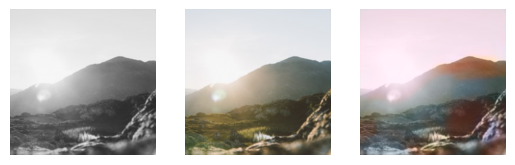

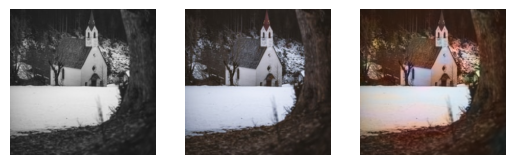

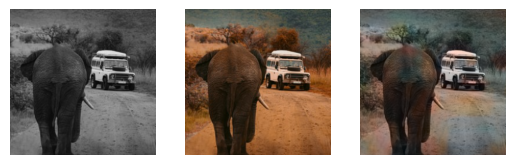

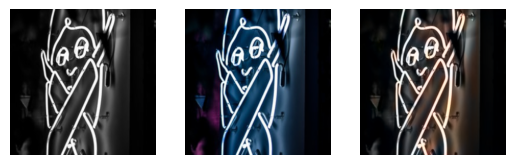

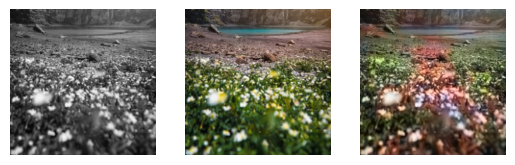

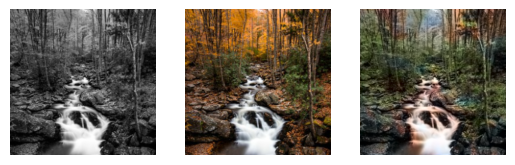

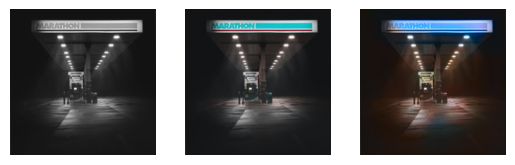

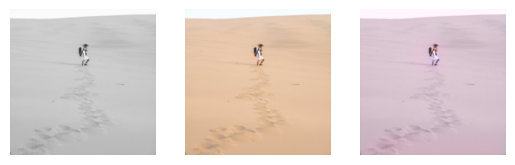

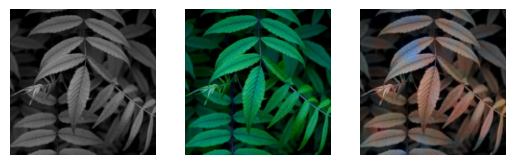

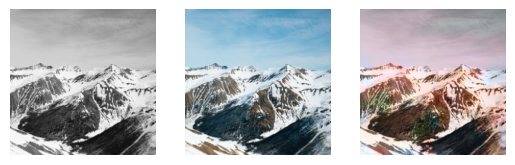

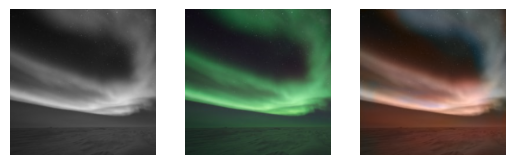

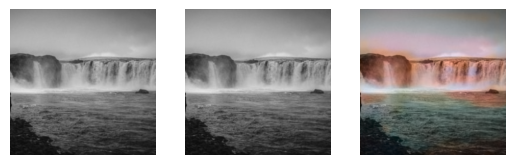

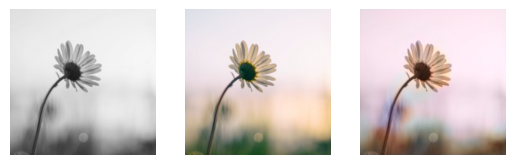

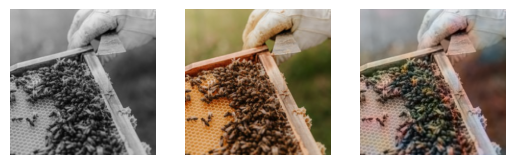

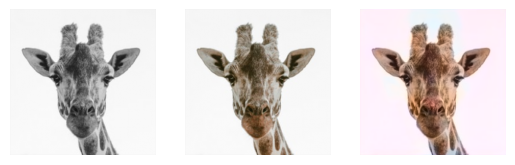

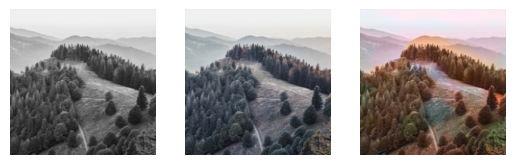

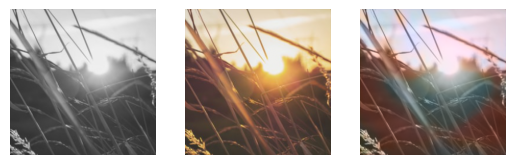

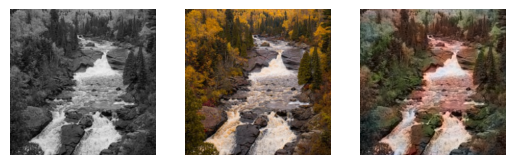

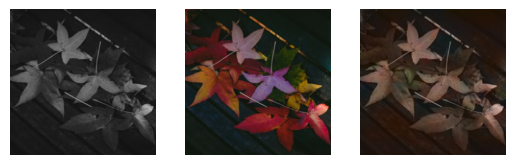

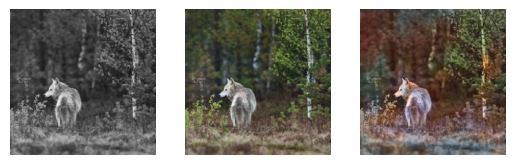

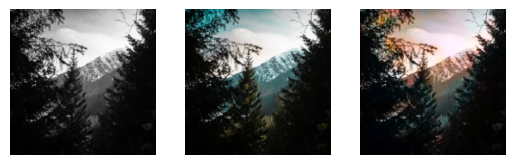

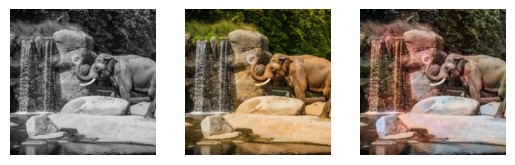

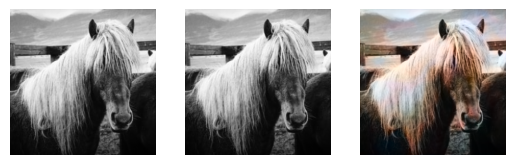

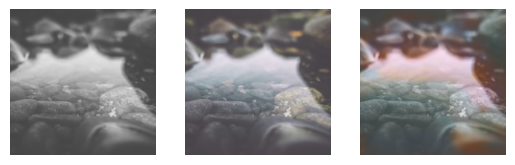

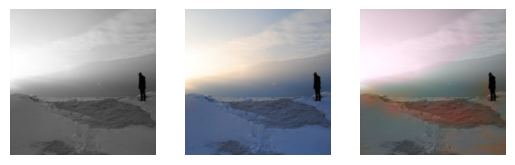

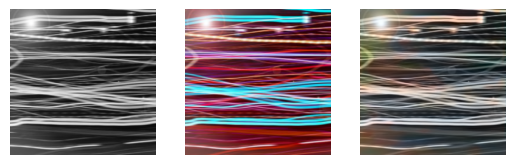

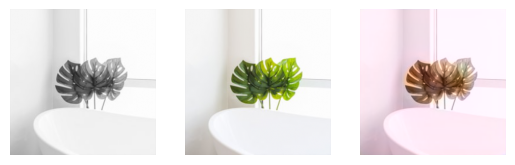

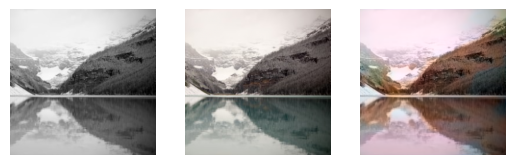

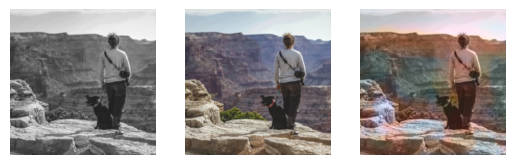

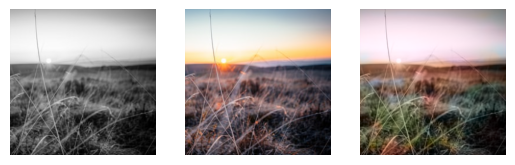

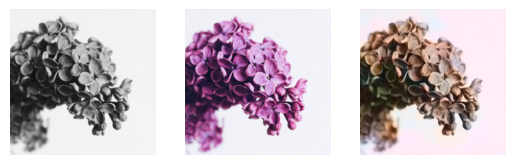

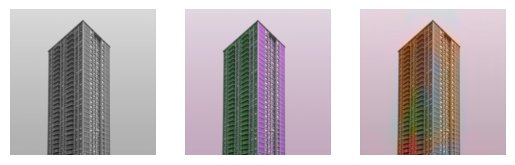

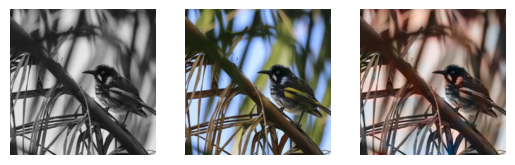

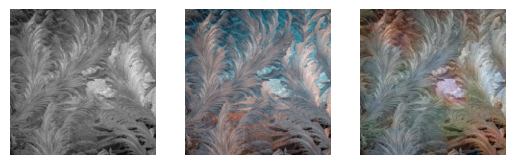

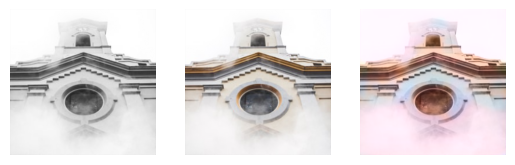

In [43]:
for i in range(len(res)):
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.imshow(x_ae_gr[i])
    plt.subplot(1,3,2) 
    plt.axis('off')
    plt.imshow(x_ae_act[i])
    plt.subplot(1,3,3) 
    plt.axis('off')
    plt.imshow(res[i])
    plt.show()